# IMPORT ESSENTIAL PYTHON LIBRARIES

In [4]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [5]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier model from Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # to plot the two-way Confusion Matrix
from sklearn.tree import plot_tree # to plot the trained Decision Tree

In [6]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# IMPORT THE DATASET

We will use the data stored in `cleaned-alzheimers-dataset.csv` created at the end of `Data Extraction and Cleaning`

In [7]:
alzheimersData = pd.read_csv('cleaned-alzheimers-dataset.csv',index_col= 0)
alzheimersData

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
4,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...
603,M,82,1.0,1.0,28.0,0.5,1693,0.694,1.037
604,M,86,1.0,1.0,26.0,0.5,1688,0.675,1.040
605,F,61,1.0,2.0,30.0,0.0,1319,0.801,1.331
606,F,63,1.0,2.0,30.0,0.0,1327,0.796,1.323


# CREATING A MODEL FOR `CDR`: Attempt 1

## Encode Categorical Variables

`DecisionTreeClassifier` in `sklearn` does not handle categorical variables directly as a part of the current implementation. Thus, there is a need to encode the levels of a categorical variable as integers. For categorical variables which may not be *ordinal*, `OneHotEncoding` from `sklearn` preprocessing module will be used.

TO CHECK: `Educ`and `SES`are already encoded as integers in the cleaned dataset. `M/F` - Gender is not ordinal. Hence, it should be encoded by `OneHotEncoding` 

In [8]:
# OneHotEncoding of categorical predictors (not the response)
alzheimersData_gender = alzheimersData[['M/F']]
ohe.fit(alzheimersData_gender)
alzheimersData_gender_ohe = pd.DataFrame(ohe.transform(alzheimersData_gender).toarray(), 
                                  columns=ohe.get_feature_names_out(alzheimersData_gender.columns))

# Check the encoded variables
alzheimersData_gender.info()

<class 'pandas.core.frame.DataFrame'>
Index: 606 entries, 0 to 607
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   M/F     606 non-null    object
dtypes: object(1)
memory usage: 9.5+ KB


In [9]:
# Assuming alzheimersData_gender_ohe is one-hot encoded gender features
alzheimersData_num = alzheimersData[['Age', 'MMSE']]
alzheimersData_cat = alzheimersData[['Educ', 'SES']]
alzheimersData_response = alzheimersData['CDR']

# Perform One-Hot Encoding on categorical features
alzheimersData_cat_ohe = pd.get_dummies(alzheimersData_cat)

# Concatenate numeric features, one-hot encoded categorical features, and response variable
alzheimersData_ohe = pd.concat([alzheimersData_num, alzheimersData_cat_ohe, alzheimersData_response], axis=1)

# Check the final dataframe
alzheimersData_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 606 entries, 0 to 607
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     606 non-null    int64  
 1   MMSE    604 non-null    float64
 2   Educ    606 non-null    float64
 3   SES     568 non-null    float64
 4   CDR     606 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 28.4 KB


## Create and Fit the Model

To ensure that 'CDR' is treated as a categorical variable representing the different classes ('Normal', 'Very Mild', 'Mild', 'Moderate'), explicitly convert it to the categorical data type using pd.Categorical().

In [10]:
alzheimersData_ohe['CDR'] = pd.Categorical(alzheimersData_ohe['CDR'], categories=[0, 0.5, 1, 2, 3], ordered=True).codes.astype(int)
print(alzheimersData_ohe['CDR'].unique())

[0 1 2 3]


Finally, after the encoding is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

In [11]:
# Extract Response and Predictors
y = pd.DataFrame(alzheimersData_ohe['CDR']) #Response
x = pd.DataFrame(alzheimersData_ohe.drop('CDR', axis = 1)) #Predictors

A simple Python function can be written and called

In [12]:
def ClassificationTree(predictor, response, depth):
    
    # Split the Legendary-Total Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(predictor, response, test_size=0.25, random_state=25)
    
    # Decision Tree using Train Data
    dectree = DecisionTreeClassifier(max_depth = depth)
    dectree.fit(X_train, y_train)
    
    # Predict Response values corresponding to Predictor
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)
    
    
    # Plot the trained Decision Tree
    f = plt.figure(figsize=(12,12))
    plot_tree(dectree, filled=True, rounded=True, 
          feature_names= X_train.columns.tolist(), # Convert Index object to list
          class_names=['Normal','Very Mild','Mild', 'Moderate', 'Severe']) 
    
    return X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, dectree

### Classification Tree Model of Max Depth 3

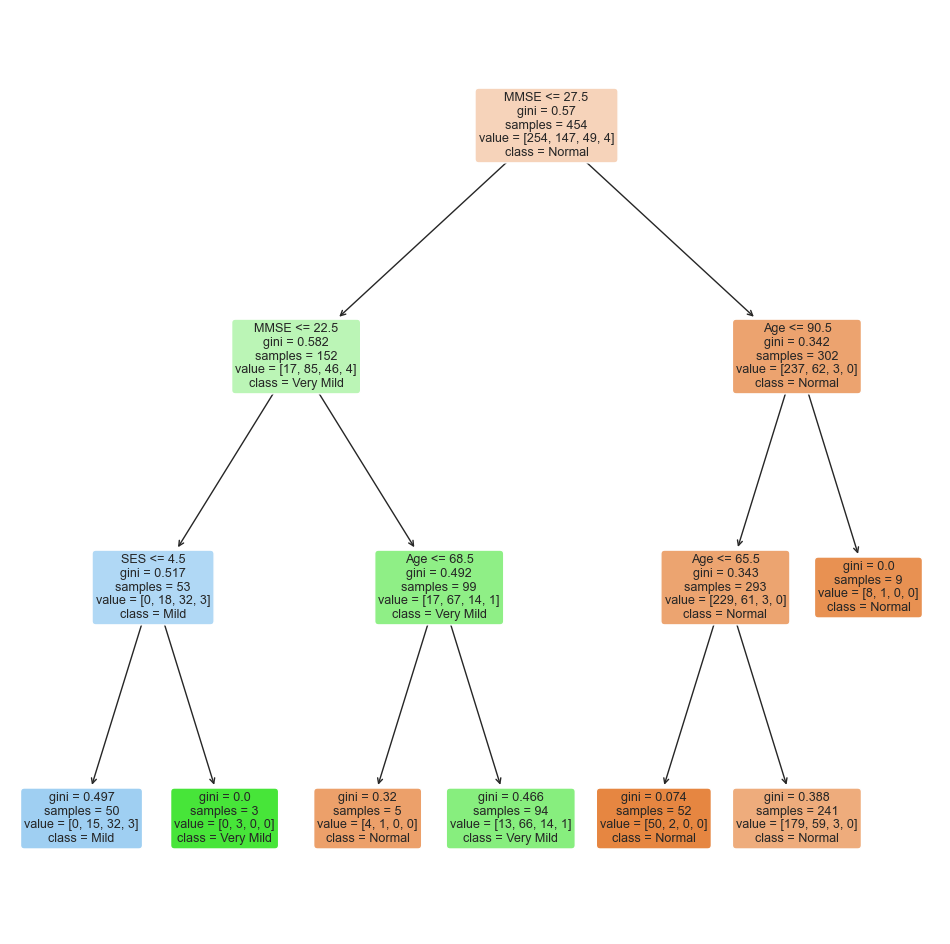

In [13]:
X_train3, X_test3, y_train3, y_test3, y_train_pred3, y_test_pred3, dectree3 = ClassificationTree(x, y, 3)

### Classification Tree Model of Max Depth 4

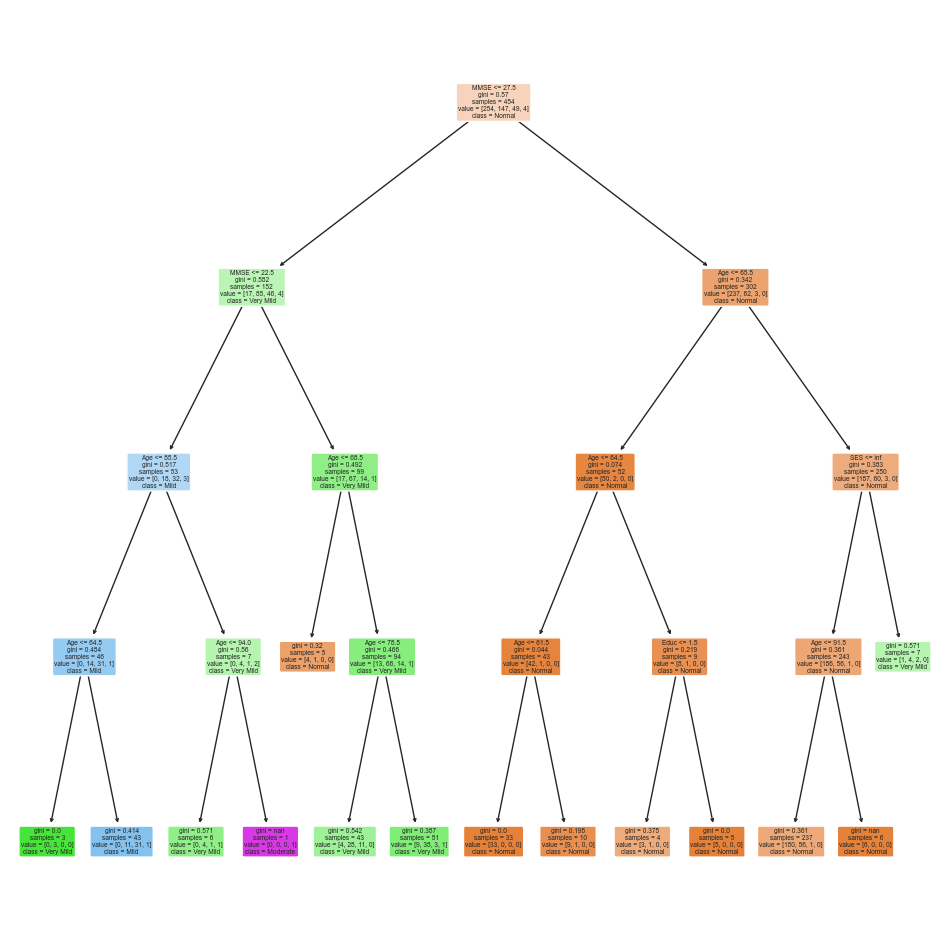

In [14]:
X_train4, X_test4, y_train4, y_test4, y_train_pred4, y_test_pred4, dectree4 = ClassificationTree (x, y, 4)

## Check the Accuracy of the Model

### Check the accuracy of the Model

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

Again, a simple Python function can be written and called

In [84]:
def confusionmatrixValues(confusionmatrix):
    tn = confusionmatrix[0][0]
    fp = confusionmatrix[0][1]
    fn = confusionmatrix[1][0]
    tp = confusionmatrix[1][1]

    return tn, fp, fn, tp

def printConfusionMatrix(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred , dectree):
    
    confusionmatrix_train = confusion_matrix(y_train, y_train_pred)
    confusionmatrix_test = confusion_matrix(y_test, y_test_pred)

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusionmatrix_train,
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusionmatrix_test, 
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


    tn_train, fp_train, fn_train, tp_train = confusionmatrixValues(confusionmatrix_train)
    tn_test, fp_test, fn_test, tp_test = confusionmatrixValues(confusionmatrix_test)
    

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", dectree.score(X_train, y_train))
    print("True Positive Rate (TPR) \t:", tp_train / (tp_train + fn_train))
    print("True Negative Rate (TNR) \t:", tn_train / (tn_train + fp_train))
    print()
    print("False Positive Rate (FPR) \t:", fp_train / (fp_train + tn_train))
    print("False Negative Rate (FNR) \t:", fn_train / (tp_train + fn_train))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", dectree.score(X_test, y_test))
    print("True Positive Rate (TPR) \t:", tp_train / (tp_train + fn_train))
    print("True Negative Rate (TNR) \t:", tn_train / (tn_train + fp_train))
    print()
    print("False Positive Rate (FPR) \t:", fp_train / (fp_train + tn_train))
    print("False Negative Rate (FNR) \t:", fn_train / (tp_train + fn_train))
    print()
    
    print()

    return

### Confusion Matrix for Classification Tree Model of Max Depth 3

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7533039647577092
True Positive Rate (TPR) 	: 0.5227272727272727
True Negative Rate (TNR) 	: 0.9488188976377953

False Positive Rate (FPR) 	: 0.051181102362204724
False Negative Rate (FNR) 	: 0.4772727272727273

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.756578947368421
True Positive Rate (TPR) 	: 0.5227272727272727
True Negative Rate (TNR) 	: 0.9488188976377953

False Positive Rate (FPR) 	: 0.051181102362204724
False Negative Rate (FNR) 	: 0.4772727272727273




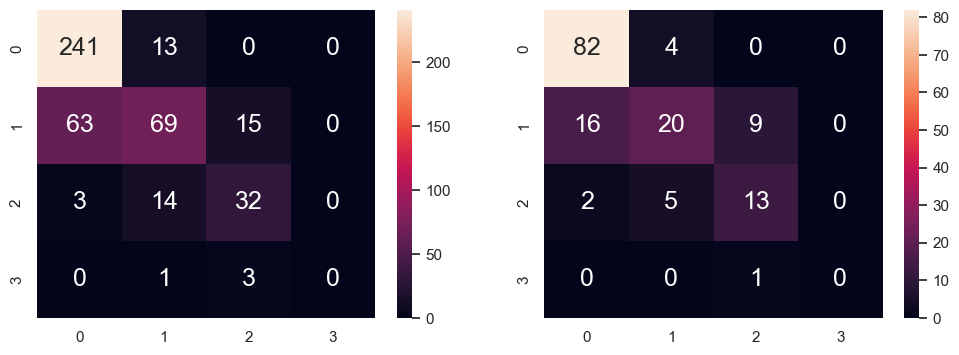

In [85]:
printConfusionMatrix(X_train3, X_test3, y_train3, y_test3, y_train_pred3, y_test_pred3, dectree3)

### Confusion Matrix for Classification Tree Model of Max Depth 4

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7687224669603524
True Positive Rate (TPR) 	: 0.5661764705882353
True Negative Rate (TNR) 	: 0.9448818897637795

False Positive Rate (FPR) 	: 0.05511811023622047
False Negative Rate (FNR) 	: 0.4338235294117647

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7960526315789473
True Positive Rate (TPR) 	: 0.5661764705882353
True Negative Rate (TNR) 	: 0.9448818897637795

False Positive Rate (FPR) 	: 0.05511811023622047
False Negative Rate (FNR) 	: 0.4338235294117647




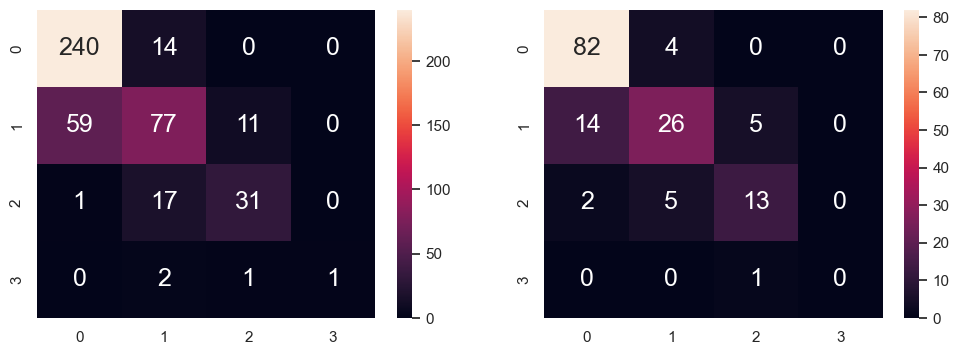

In [86]:
printConfusionMatrix(X_train4, X_test4, y_train4, y_test4, y_train_pred4, y_test_pred4, dectree4)

---

## Create a Model for Rating : Attempt 2

Let's refine the previous model by balancing the classes of the response `Rating` in the training data. Keeping the OneHotEncoding same as before.

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
import warnings

# Identify the different classes and their counts in the 'CDR' column
cdr_value_counts = alzheimersData['CDR'].value_counts()

# Find the majority class and its count
majority_class = cdr_value_counts.idxmax()
majority_class_count = cdr_value_counts.max()

# Split the dataset into subsets based on the value of the 'CDR' variable
subsets = {cdr_value: alzheimersData[alzheimersData['CDR'] == cdr_value] for cdr_value in cdr_value_counts.index}

# Upsample minority classes
upsampled_subsets = [subsets[majority_class]]  # start with the majority class

for cdr_value, subset in subsets.items():
    if cdr_value != majority_class:  # only upsample minority classes
        upsampled_subset = resample(subset,
                                    replace=True,
                                    n_samples=majority_class_count,  # match number in majority class
                                    random_state=42)  # reproducible results
        upsampled_subsets.append(upsampled_subset)

# Combine the upsampled classes with the majority class to form a balanced dataset
balanced_alzheimers_data = pd.concat(upsampled_subsets)

# Check the new value counts to ensure the classes are balanced
balanced_value_counts = balanced_alzheimers_data['CDR'].value_counts()
balanced_value_counts

CDR
0.0    340
0.5    340
1.0    340
2.0    340
Name: count, dtype: int64

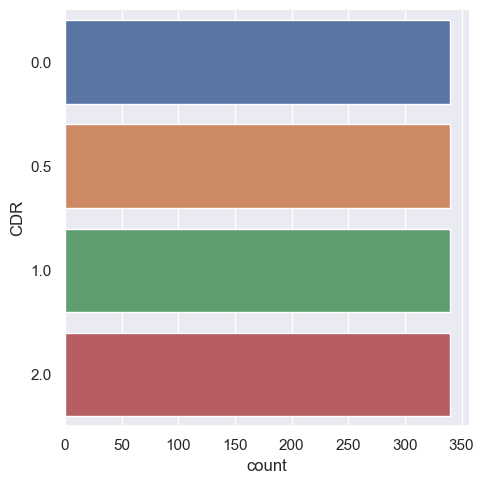

In [102]:
warnings.filterwarnings('ignore', message='The figure layout has changed to tight')

# Quick plot to check the balanced classes visually
sb.catplot(y = 'CDR', data = balanced_alzheimers_data, kind = "count")

In [103]:
# Confirm that the OHE is still in place
# and that the samples have now increased
balanced_alzheimers_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1360 entries, 0 to 486
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     1360 non-null   object 
 1   Age     1360 non-null   int64  
 2   Educ    1360 non-null   float64
 3   SES     1267 non-null   float64
 4   MMSE    1353 non-null   float64
 5   CDR     1360 non-null   float64
 6   eTIV    1360 non-null   int64  
 7   nWBV    1360 non-null   float64
 8   ASF     1360 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 106.2+ KB


### Create and Fit the Model

Finally, after the encoding and upsampling is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

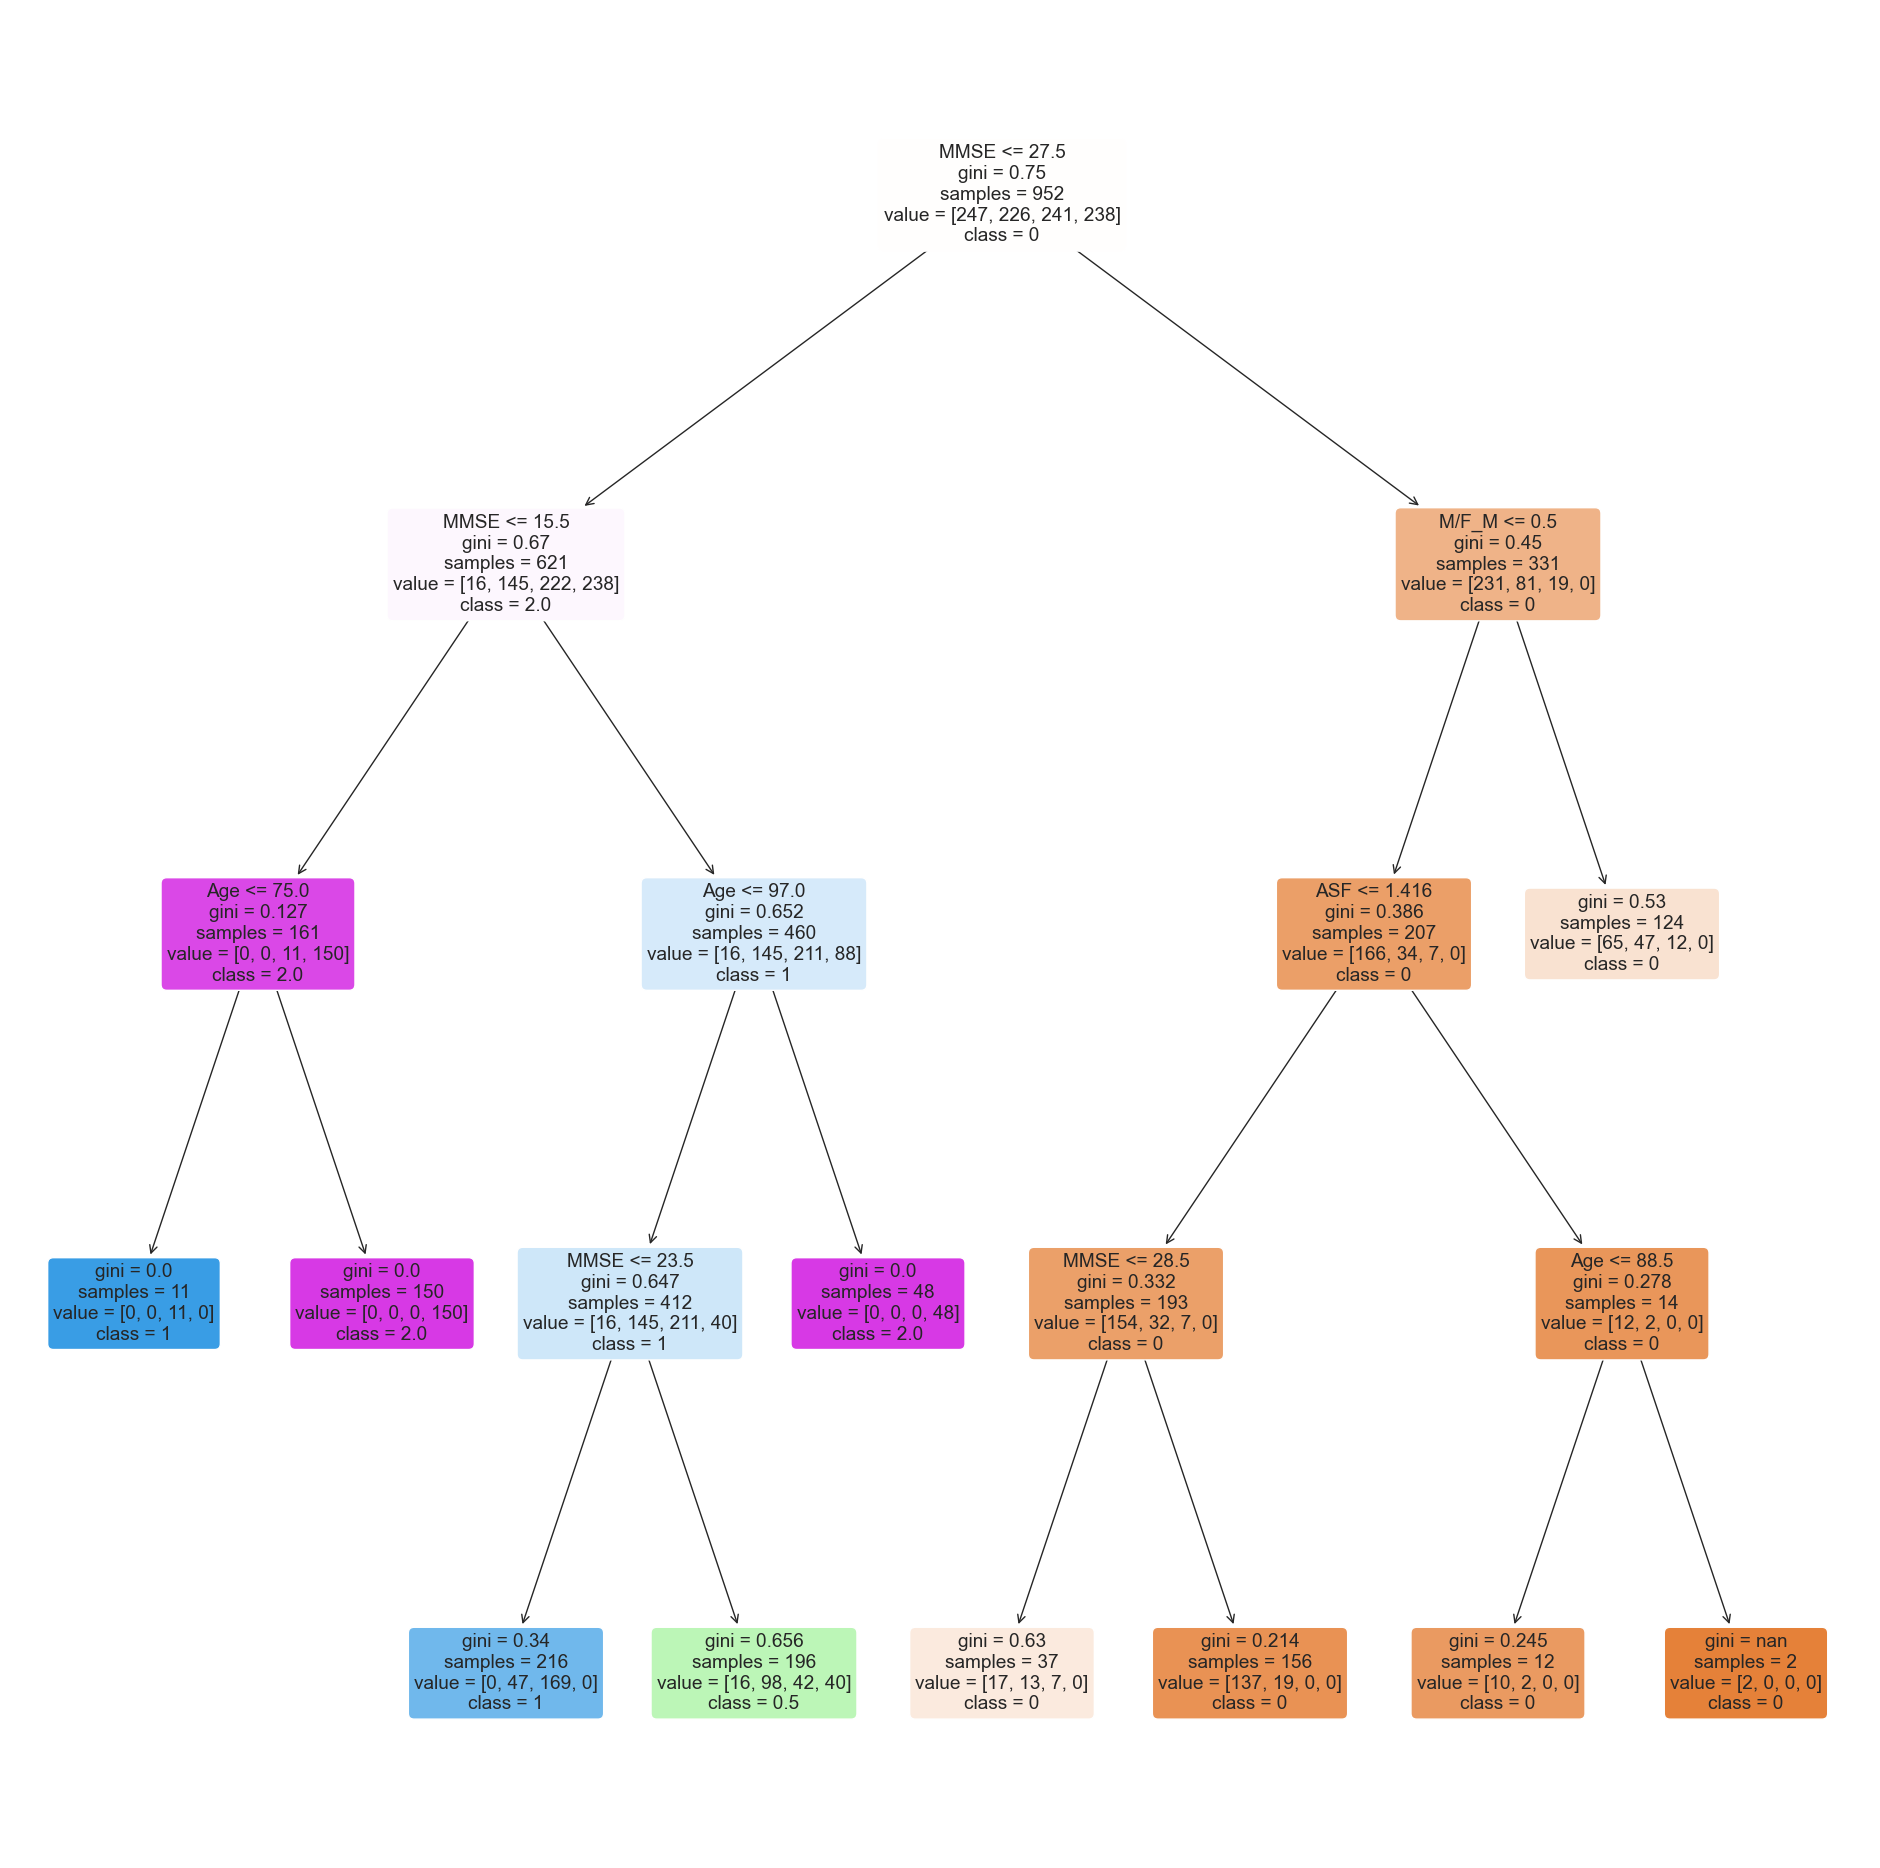

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

# Assuming 'balanced_alzheimers_data' is your DataFrame
# Convert 'CDR' column to categorical and encode
balanced_alzheimers_data['CDR'] = pd.Categorical(balanced_alzheimers_data['CDR'])
balanced_alzheimers_data['CDR'] = balanced_alzheimers_data['CDR'].cat.codes

# Identify categorical columns (modify this list based on your actual categorical columns)
categorical_cols = balanced_alzheimers_data.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical columns
balanced_alzheimers_data = pd.get_dummies(balanced_alzheimers_data, columns=categorical_cols)

# Split the Dataset into Train and Test
X = balanced_alzheimers_data.drop('CDR', axis=1)
y = balanced_alzheimers_data['CDR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth=4)
dectree.fit(X_train, y_train)

# Plot the trained Decision Tree
plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, feature_names=list(X_train.columns), class_names=["0","0.5","1","2.0"])
plt.show()


### Check the accuracy of the Model

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

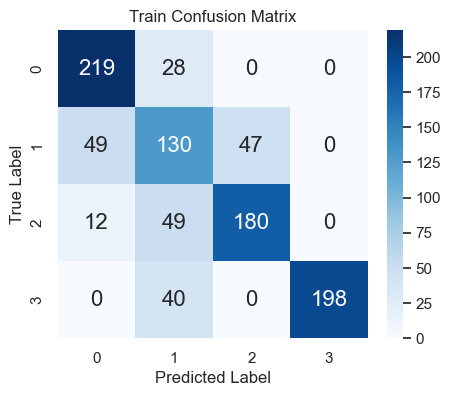

Train Data:
Accuracy: 0.7637
True Positive Rate: 0.7263
True Negative Rate: 0.8866


False Positive Rate: 0.1134
False Negative Rate: 0.2737


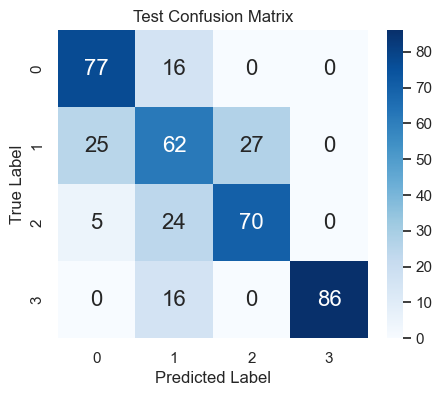

Test Data:
Accuracy: 0.7230
True Positive Rate: 0.7126
True Negative Rate: 0.8280


False Positive Rate: 0.1720
False Negative Rate: 0.2874


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import plot_tree

def print_performance_metrics(y_true, y_pred, dataset_type):
    """ Prints the performance metrics for the provided dataset type (Train/Test). """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (cm[0][0], cm[0][1], cm[1][0], cm[1][1])
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = fp / (tn + fp)
    fnr = fn / (tp + fn)

    # Plotting the confusion matrix
    plt.figure(figsize=(5, 4))
    sb.heatmap(cm, annot=True, fmt="d", cmap='Blues', annot_kws={"size": 16})
    plt.title(f'{dataset_type} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Printing metrics
    print(f"{dataset_type} Data:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate: {tpr:.4f}")
    print(f"True Negative Rate: {tnr:.4f}")
    print("\n")
    print(f"False Positive Rate: {fpr:.4f}")
    print(f"False Negative Rate: {fnr:.4f}")

def evaluate_decision_tree():
    # Load and prepare data (assuming balanced_alzheimers_data is preloaded and 'CDR' is coded)
    X = balanced_alzheimers_data.drop('CDR', axis=1)
    y = balanced_alzheimers_data['CDR']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train the decision tree model
    dectree = DecisionTreeClassifier(max_depth=4)
    dectree.fit(X_train, y_train)

    # Prediction
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)

    # Evaluate and print performance metrics for training data
    print_performance_metrics(y_train, y_train_pred, "Train")

    # Evaluate and print performance metrics for testing data
    print_performance_metrics(y_test, y_test_pred, "Test")

# Run the evaluation
evaluate_decision_tree()


The false positives and false negatives are more balanced now. But, there is room for improvement.